In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
import glob
from keras.models import Sequential
from keras.layers import *
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
remote = callbacks.RemoteMonitor(root='http://localhost:9000')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tqdm import tqdm_notebook as tq
from random import shuffle
import os
from keras.utils.visualize_util import plot
from keras.optimizers import *
from shutil import copyfile
import sys;
from keras.models import load_model
from keras.regularizers import l2
sys.setrecursionlimit(40000)

%matplotlib inline

target_size = (64,64)
channel = 1


Using Theano backend.
Using gpu device 0: GeForce GTX 970 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5105)


In [2]:
train_datagen = ImageDataGenerator(
    rotation_range=1,
    width_shift_range=0.01,
    height_shift_range=0.01,
    shear_range=0.0005,
    noise = 2)
test_datagen = ImageDataGenerator()


In [3]:
train_generator = train_datagen.flow_from_directory('boats_id_train - Copy_gen', batch_size=128, 
                                                    target_size=target_size, color_mode="grayscale")
validation_generator = test_datagen.flow_from_directory('boats_id_test_gen', batch_size=128, target_size=target_size, 
                                                        color_mode="grayscale")

Found 28176 images belonging to 18 classes.
Found 7170 images belonging to 18 classes.


In [4]:
model = Sequential()
model.add(Activation(activation="relu", input_shape=(channel,) + target_size))
model.add(Convolution2D(3, 3, 3, border_mode='same', activation='relu', W_regularizer=l2(0.0001)))
model.add(Convolution2D(3, 3, 3, border_mode='same', activation='relu', W_regularizer=l2(0.0001)))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Convolution2D(9, 3, 3, border_mode='same', activation='relu', W_regularizer=l2(0.0001)))
model.add(Convolution2D(9, 3, 3, border_mode='same', activation='relu', W_regularizer=l2(0.0001)))
model.add(Dropout(0.02))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Convolution2D(9, 3, 3, border_mode='same', activation='relu', W_regularizer=l2(0.0001)))
model.add(Convolution2D(9, 3, 3, border_mode='same', activation='relu', W_regularizer=l2(0.0001)))
model.add(Dropout(0.02))
model.add(Flatten())

model.add(Dense(9, activation='relu', W_regularizer=l2(0.001)))
model.add(Dense(18, activation='relu', W_regularizer=l2(0.001)))
model.add(Activation('softmax'))

In [5]:
model = Sequential()
model.add(Activation(activation="relu", input_shape=(channel,) + target_size))
model.add(LocallyConnected2D(3, 1, 1, activation='relu'))
model.add(GlobalMaxPooling2D())

model.add(Dense(18, activation='relu'))
model.add(Activation('softmax'))

In [ ]:
model = Sequential()
model.add(Activation(activation="relu", input_shape=(channel,) + target_size))
model.add(Convolution2D(10, 2, 2, border_mode='same', activation='relu'))
model.add(Dropout(0.05))
model.add(Convolution2D(10, 2, 2, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(LocallyConnected2D(5, 3, 3, activation='relu'))
model.add(LocallyConnected2D(5, 3, 3, activation='relu'))
model.add(GlobalMaxPooling2D())

model.add(Dense(16, activation='relu'))

model.add(Dense(18, activation='relu'))
model.add(Activation('softmax'))

In [5]:
plot(model, to_file='nn_boat.png',show_shapes=True)

In [5]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
activation_1 (Activation)        (None, 1, 64, 64)     0           activation_input_1[0][0]         
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 3, 64, 64)     30          activation_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 3, 64, 64)     84          convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 3, 21, 21)     0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [6]:
opt = SGD(lr=0.03, decay=0.01)
#opt = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=["accuracy"])

In [7]:
# train the model on the new data for a few epochs
model.fit_generator(train_generator,
        samples_per_epoch=1024,
        nb_epoch=1000,
        validation_data=validation_generator,
        verbose=0,
        nb_val_samples=256, callbacks=[remote])

C:\Program Files\Anaconda3\lib\site-packages\keras\keras\engine\training.py:1472: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


KeyboardInterrupt: 

In [8]:
#model.save("cool_model_boats_id.h5")

In [ ]:
#model = load_model('cool_model_boats_id.h5')

In [9]:
validation_generator = test_datagen.flow_from_directory('boats_id_test', batch_size=32, target_size=target_size, 
                                                        color_mode="grayscale")

Found 90 images belonging to 18 classes.


In [10]:
model.evaluate_generator(validation_generator,500)

[0.14015759391427504, 0.92412451361867709]

In [11]:
model.metrics_names

['loss', 'acc']

In [ ]:
c=0
for X, Y in validation_generator:
    Y_pred = model.predict(X)
    for i in range(len(X)):
        im = np.rollaxis(np.array(X[i]), 0, 3) *-1
        np.roll(im, 1, axis=-1)
        #im = np.roll(X[i], 1, axis=-1)
        im = X[i][0]
        #print(np.shape(im))
        plt.imshow(im, cmap=plt.cm.gray)
        plt.show()

        print("prediction on true: " +  str(Y_pred[i][list(Y[i]).index(1)]))
        print("other prediction: " + str(np.max(Y_pred[i])))

        c +=1
    
    if c >15:
        break

Now we'll see how things work out if we use a treashold:

In [ ]:
c=0
for X, Y in validation_generator:
    Y_pred = model.predict(X)
    for i in range(len(X)):
        if Y_pred[i][list(Y[i]).index(1)] <0.5 and np.max(Y_pred[i]) >0.70:
            im = np.rollaxis(np.array(X[i]), 0, 3) *-1
            np.roll(im, 1, axis=-1)
            #im = np.roll(X[i], 1, axis=-1)
            im = X[i][0]
            
            #plt.imshow(im, cmap=plt.cm.gray)
            #plt.show()

            #print("True value:" + str(Y_batch[i]))
            #print("Predicted value" + str(results[i]))
            print("prediction on true: " +  str(Y_pred[i][list(Y[i]).index(1)]))
            print("other prediction: " + str(np.max(Y_pred[i])))

            #print(dic[a], p*100,"%")
            c +=1
    
    if c >5:
        break

In [57]:
t = tq(total=500)

trust_on_bad_guesses = []
c=0
for X, Y in validation_generator:
    Y_pred = model.predict(X)
    for i in range(len(X)):
        if np.argmax(Y[i]) != np.argmax(Y_pred[i]) :
            #im = np.rollaxis(np.array(X[i]), 0, 3) *-1
            #np.roll(im, 1, axis=-1)
            #im = np.roll(X[i], 1, axis=-1)
            #im = X[i][0]
            trust_on_bad_guesses.append(np.max(Y_pred[i]))
            #plt.imshow(im, cmap=plt.cm.gray)
            #plt.show()

            #print("True value:" + str(Y_batch[i]))
            #print("Predicted value" + str(results[i]))
            #print("prediction on true: " +  str(Y_pred[i][list(Y[i]).index(1)]))
            #print("other prediction: " + str(np.max(Y_pred[i])))

            #print(dic[a], p*100,"%")
            c +=1
            t.update()
    
    if c > 500:
        break
t.close()

In [58]:
t = tq(total=500)

trust_on_good_guesses = []
c=0
for X, Y in validation_generator:
    Y_pred = model.predict(X)
    for i in range(len(X)):
        if np.argmax(Y[i]) == np.argmax(Y_pred[i]) :
            #im = np.rollaxis(np.array(X[i]), 0, 3) *-1
            #np.roll(im, 1, axis=-1)
            #im = np.roll(X[i], 1, axis=-1)
            #im = X[i][0]
            trust_on_good_guesses.append(np.max(Y_pred[i]))
            #plt.imshow(im, cmap=plt.cm.gray)
            #plt.show()

            #print("True value:" + str(Y_batch[i]))
            #print("Predicted value" + str(results[i]))
            #print("prediction on true: " +  str(Y_pred[i][list(Y[i]).index(1)]))
            #print("other prediction: " + str(np.max(Y_pred[i])))

            #print(dic[a], p*100,"%")
            c +=1
            t.update()
    
    if c > 500:
        break
t.close()

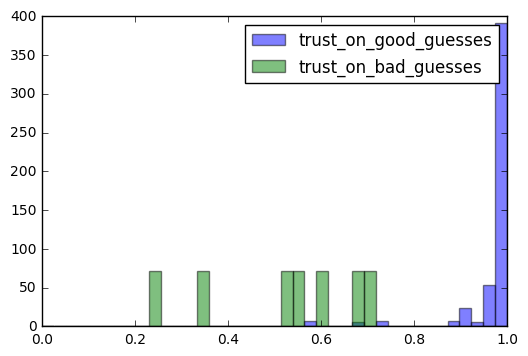

In [59]:
bins = np.linspace(0, 1, 40)

plt.hist(trust_on_good_guesses, bins, alpha=0.5, label='trust_on_good_guesses')
plt.hist(trust_on_bad_guesses, bins, alpha=0.5, label='trust_on_bad_guesses')
plt.legend(loc='upper right')
plt.show()

boats_id_train - Copy/0


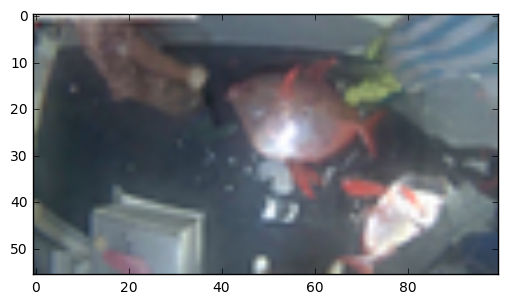

boats_id_train - Copy/1


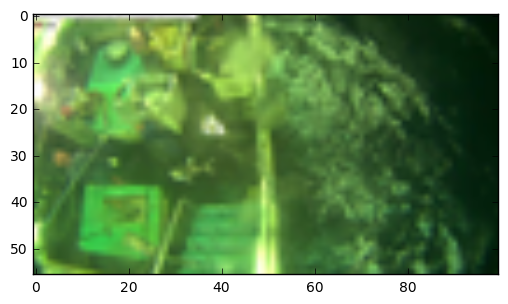

boats_id_train - Copy/10


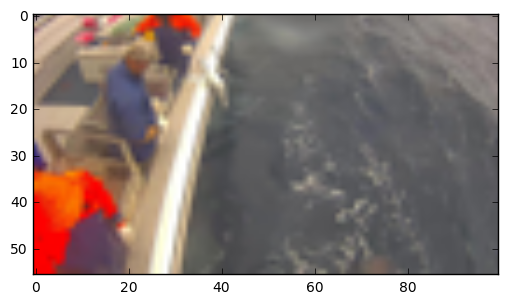

boats_id_train - Copy/11


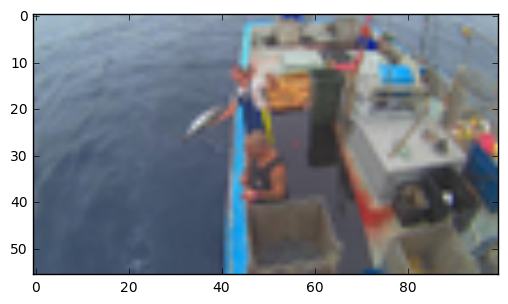

boats_id_train - Copy/12


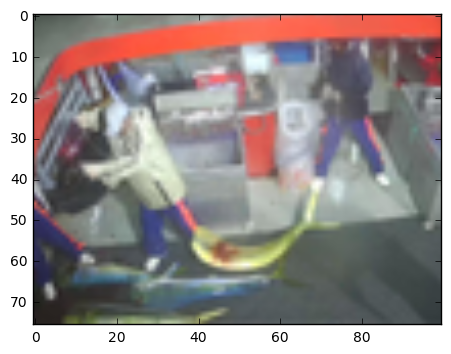

boats_id_train - Copy/13


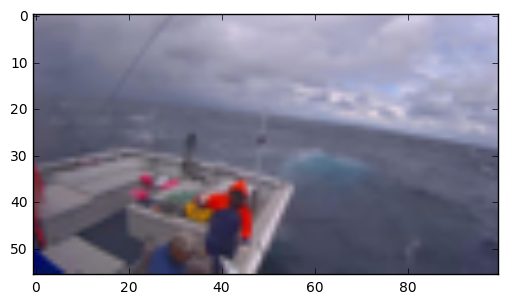

boats_id_train - Copy/14


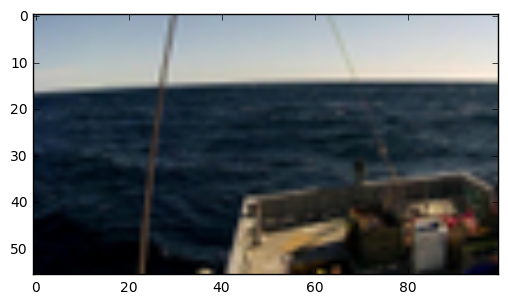

boats_id_train - Copy/15


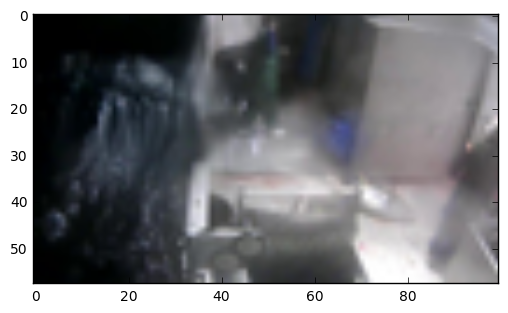

boats_id_train - Copy/16


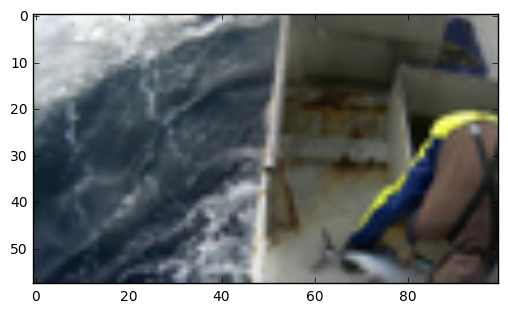

boats_id_train - Copy/17


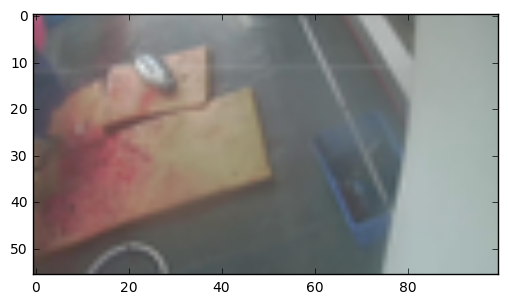

boats_id_train - Copy/2


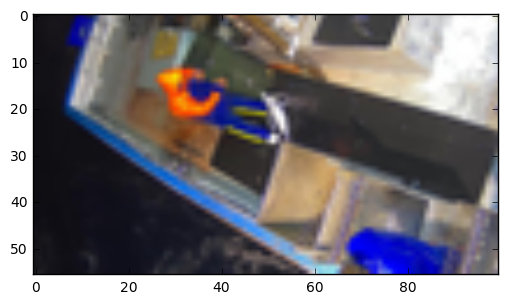

boats_id_train - Copy/3


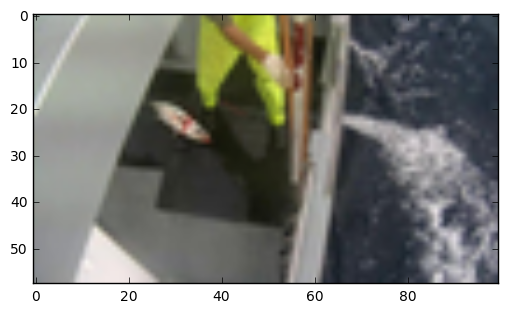

boats_id_train - Copy/4


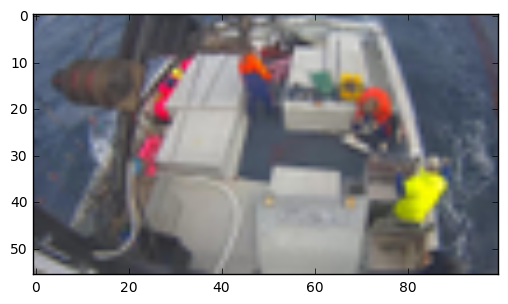

boats_id_train - Copy/5


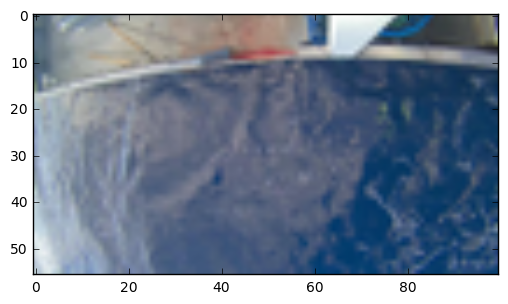

boats_id_train - Copy/6


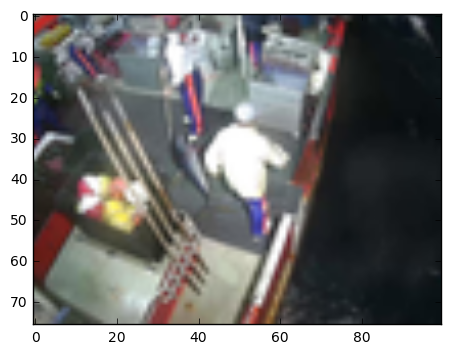

boats_id_train - Copy/7


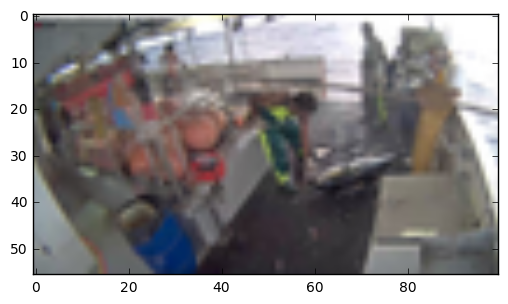

boats_id_train - Copy/8


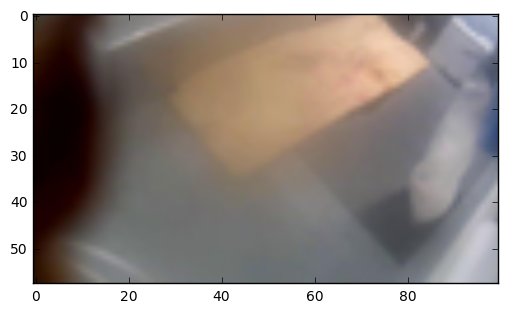

boats_id_train - Copy/9


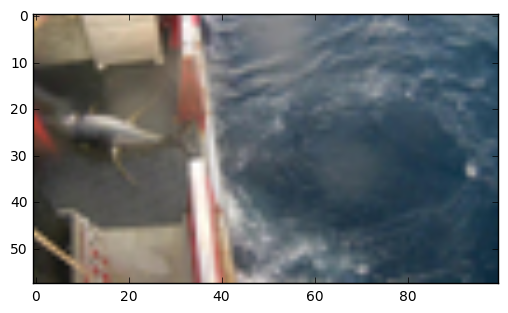

In [62]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
for string in os.listdir("boats_id_train - Copy"):
    print("boats_id_train - Copy/" + string)
    path = "boats_id_train - Copy/"+ string + "/" + os.listdir("boats_id_train - Copy/" + string)[3]
    img=Image.open(path)
    img.thumbnail((100, 100), Image.ANTIALIAS)
    plt.imshow(img)
    plt.show()